# Design and Proficiency: Task 3

Improving model efficiency and accuracy for deep CNNs (ShuffleNetV2b) with compound scaling.

Team Members:

*   2020E169 - WEERAKOON A. B.
*   2020E180 - WIJEPALA N. G. N. D.
*   2020E182 - WIJESINGHE L. A. D. P. A.



## Introduction

Scaling up CNNs typically improves accuracy but increases compute and memory super‑linearly. EfficientNet formalized a compound scaling method that balances depth, width, and resolution via a small set of coefficients, achieving strong accuracy‑efficiency trade‑offs on ImageNet. Our objective is to replicate the spirit of compound scaling under a tighter resource envelope by starting from a mobile‑class model, ShuffleNet v2b, and designing a reproducible scaling method that reaches ~5M parameters (≈ EfficientNet‑B0/B1 scale) while preserving (and arguably improving) inference efficiency.

For this task, tensorflow, tensorflow for computer vision (tf2cv) and wandb were used.

## Implementation

Following section outlines the complete implementation code of our model, tuning, scaling and evaluating.

Additional: Sweep configuration for step one was as follows,


```
method: bayes
metric:
  goal: maximize
  name: test_acc
name: tune_alpha_beta_gamma
parameters:
  beta:
    distribution: q_uniform
    max: 1.4
    min: 1
    q: 0.01
  gamma:
    distribution: q_uniform
    max: 1.4
    min: 1
    q: 0.01
  phi:
    value: 1
  scaling_constant_offset:
    distribution: q_uniform
    max: 0.2
    min: -0.2
    q: 0.02

```



### Install and import dependencies

Imports,
* wandb for sweeping through different model scales
* tensorflow for neural networking
* numpy for dataset configuration
* tf2cv for loading pretrained weights for ShuffleNetV2 on ImageNet
* os for processing through the found ImageNet dataset
* drive for connecting to google drive and fetching the ImageNet dataset

In [ ]:
!pip install wandb tf2cv tensorflow tensorflow_datasets tqdm --quiet

import wandb
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from google.colab import drive
from math import ceil
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.7/123.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 194.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.5/415.5 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 142.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.0/381.0 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 130.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 161.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

### Build a scaling method to scale ShuffleNetV2 optimally utilizing pretrained weights in ImageNet dataset

This method produces a scaled model of ShuffleNetV2 taking width and depth multipliers and resolution.
This method,
* Creates a base ShuffleNetv2b x0.5 model
* Multiplies layers and filter count based on depth and width scaling
* Adjusts input layer resolution based on given resolution
* Returns a scaled ShuffleNetV2b model

#### ShuffleNet Layers

Implements additional ShuffleNet layers introduced in the original ShuffleNet paper.

In [ ]:
class ChannelShuffle(keras.layers.Layer):
    def __init__(self, groups=2, **kwargs):
        super().__init__(**kwargs)
        self.groups = groups

    def call(self, x):
        batch_size, h, w, c = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        group_channels = c // self.groups
        x = tf.reshape(x, [batch_size, h, w, self.groups, group_channels])
        x = tf.transpose(x, [0, 1, 2, 4, 3])
        x = tf.reshape(x, [batch_size, h, w, c])
        return x

class ShuffleSplit(keras.layers.Layer):
    def call(self, x):
        return tf.split(x, num_or_size_splits=2, axis=-1)

def shufflenet_unit(x, out_channels, stride, groups=2):
    inp_channels = x.shape[-1]
    half_out = out_channels // 2

    if stride == 1:
        x1, x2 = ShuffleSplit()(x)
        y = x2
        y = keras.layers.Conv2D(half_out, 1, padding='same', use_bias=False)(y)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.ReLU()(y)
        y = keras.layers.DepthwiseConv2D(3, strides=stride, padding='same', use_bias=False)(y)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.Conv2D(half_out, 1, padding='same', use_bias=False)(y)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.ReLU()(y)
        out = keras.layers.Concatenate()([x1, y])
    else:
        y = keras.layers.Conv2D(half_out, 1, padding='same', use_bias=False)(x)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.ReLU()(y)
        y = keras.layers.DepthwiseConv2D(3, strides=stride, padding='same', use_bias=False)(y)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.Conv2D(half_out, 1, padding='same', use_bias=False)(y)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.ReLU()(y)

        x_proj = keras.layers.DepthwiseConv2D(3, strides=stride, padding='same', use_bias=False)(x)
        x_proj = keras.layers.BatchNormalization()(x_proj)
        x_proj = keras.layers.Conv2D(half_out, 1, padding='same', use_bias=False)(x_proj)
        x_proj = keras.layers.BatchNormalization()(x_proj)
        x_proj = keras.layers.ReLU()(x_proj)

        out = keras.layers.Concatenate()([x_proj, y])

    out = ChannelShuffle(groups=groups)(out)
    return out

def make_stage(x, out_channels, repeat, stride_first=2):
    x = shufflenet_unit(x, out_channels, stride=stride_first)
    for _ in range(repeat - 1):
        x = shufflenet_unit(x, out_channels, stride=1)
    return x

#### Build scaled ShuffleNetV2b

Method to return a scaled version of ShuffleNetV2 created from scratch.

In [ ]:
# set random seed for guarenteeing reproducibility
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [ ]:
# method to produce scaled versions of ShuffleNetV2b x0.5
def get_shufflenet_scaled(width=1.0, resolution=224, depth_mult=1.0, num_classes=1000):

    # scaling methods with rounding
    def round_filters(filters, width, divisor=8):
        filters *= width
        new_filters = max(divisor, int(filters + divisor / 2) // divisor * divisor)
        if new_filters < 0.9 * filters:
            new_filters += divisor
        return int(new_filters)

    def round_repeats(repeats, depth_mult):
        return int(np.ceil(repeats * depth_mult))

    # stage channel configuration (ShuffleNetV2b paper)
    base_channels = [24, 48, 96, 192, 1024]  # output channels after each stage
    channels_scaled = [round_filters(c, width) for c in base_channels[:-1]] + [base_channels[-1]]
    base_repeats = [4, 8, 4]  # stage2, stage3, stage4
    repeats_scaled = [round_repeats(r, depth_mult) for r in base_repeats]

    inputs = keras.Input(shape=(resolution, resolution, 3))
    x = keras.layers.Conv2D(channels_scaled[0], 3, strides=2, padding='same', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # stage 2-4
    x = make_stage(x, channels_scaled[1], repeats_scaled[0], stride_first=2)
    x = make_stage(x, channels_scaled[2], repeats_scaled[1], stride_first=2)
    x = make_stage(x, channels_scaled[3], repeats_scaled[2], stride_first=2)

    # final conv
    x = keras.layers.Conv2D(channels_scaled[4], 1, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # classifier
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name=f"shufflenet_scaled_{width:.2f}x")
    print(f"Built ShuffleNetV2b scaled: width={width}, depth_mult={depth_mult}, res={resolution}")
    return model

#### (Optional) Print layers of newly created base ShuffleNetV2b model

In [ ]:
scaled_model = get_shufflenet_scaled(width=1.0, depth_mult=1.0, resolution=224, num_classes=1000)

print("=== Newly created ShuffleNetV2b ===")
scaled_model.summary()
# for i, layer in enumerate(scaled_model.layers):
#     print(f"{i:03d}: {layer.name} | {layer.__class__.__name__} | output_shape: {getattr(layer, 'output_shape', 'unknown')}")

Built ShuffleNetV2b scaled: width=1.0, depth_mult=1.0, res=224
=== Newly created ShuffleNetV2b ===


Model: "shufflenet_scaled_1.00x"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        648 │ input_layer[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │        576 │ max_pooling2d[0]… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 28, 28,    │        216 │ max_pooling2d[0]… │
│ (DepthwiseConv2D)   │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 28, 28,    │        216 │ re_lu_1[0][0]     │
│ (DepthwiseConv2D)   │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │         96 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │         96 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │        576 │ batch_normalizat… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │        576 │ batch_normalizat… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │         96 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │         96 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 1,374,744 (5.24 MB)

 Trainable params: 1,366,792 (5.21 MB)

 Non-trainable params: 7,952 (31.06 KB)

### Mount google drive and prepare datasets

Loads images from google drive as a tensorflow dataset with prefetch in order to minimize disk usage on the virtual machine.

In [ ]:
# mount google drive
drive.mount('/content/drive', force_remount=True)

# path to ImageNet dataset
DATA_DIR = "/content/drive/MyDrive/Task3/dataset"

# parameters
BATCH_SIZE = 128
SEED = 123
AUTOTUNE = tf.data.AUTOTUNE

# verify categories (only fetch first 100)
categories = sorted([d for d in os.listdir(DATA_DIR) if
                     os.path.isdir(os.path.join(DATA_DIR, d))])[:100]
num_classes = len(categories)
print(f"Found {num_classes} categories.")
print("Example categories:", categories[:5])

def split_image_paths(data_dir, categories,
                      n_train=210, n_val=60, n_test=30,
                      seed=42):

    random.seed(seed)
    train_paths, val_paths, test_paths = [], [], []

    # total requested
    total_req = n_train + n_val + n_test
    if total_req == 0:
        raise ValueError("Total requested images (train+val+test) must be > 0")

    for cls in tqdm(categories):
        cls_path = os.path.join(data_dir, cls)
        imgs = sorted([
            os.path.join(cls_path, f)
            for f in os.listdir(cls_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

        n_total = len(imgs)
        if n_total == 0:
            continue  # skip empty categories

        random.shuffle(imgs)

        if n_total < total_req:
            # scale down proportionally
            ratio_train = n_train / total_req
            ratio_val   = n_val / total_req
            ratio_test  = n_test / total_req

            n_train_adj = max(1, int(ratio_train * n_total))
            n_val_adj   = max(1, int(ratio_val * n_total))
            n_test_adj  = max(1, n_total - n_train_adj - n_val_adj)
        else:
            n_train_adj = n_train
            n_val_adj   = n_val
            n_test_adj  = n_test

        # Adjust if rounding causes overflow
        if n_train_adj + n_val_adj + n_test_adj > n_total:
            n_test_adj = max(1, n_total - n_train_adj - n_val_adj)


        train_paths.extend(imgs[:n_train_adj])
        val_paths.extend(imgs[n_train_adj:n_train_adj + n_val_adj])
        test_paths.extend(imgs[n_train_adj + n_val_adj:
                               n_train_adj + n_val_adj + n_test_adj])

    return train_paths, val_paths, test_paths


# Example usage:
train_paths, val_paths, test_paths = split_image_paths(DATA_DIR, categories)

print(f"Train: {len(train_paths)} | Val: {len(val_paths)} | Test: {len(test_paths)}")


# make_dataset stays the same
def make_dataset(file_paths, labels, img_size=224, batch_size=128, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    def load_and_preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (img_size, img_size))
        img = tf.cast(img, tf.float32) / 255.0
        return img, tf.one_hot(label, num_classes)

    if shuffle and len(file_paths) > 0:
        ds = ds.shuffle(buffer_size=len(file_paths), seed=SEED)
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).cache().prefetch(AUTOTUNE)
    return ds

# assign integer labels
label_map = {cls: i for i, cls in enumerate(categories)}
train_labels = [label_map[os.path.basename(os.path.dirname(p))] for p in train_paths]
val_labels = [label_map[os.path.basename(os.path.dirname(p))] for p in val_paths]
test_labels = [label_map[os.path.basename(os.path.dirname(p))] for p in test_paths]

Mounted at /content/drive
Found 100 categories.
Example categories: ['abacus', 'abaya', 'academic_gown', 'accordion', 'acorn']


  0%|          | 0/100 [00:00<?, ?it/s]

Train: 20897 | Val: 5970 | Test: 2986


### Encapsulated method for building a scaled ShuffleNetV2 model, training it and evaluating it

In [ ]:
# train scaled shuffleNet with width, depth and resolution parameters
def train_scaled_shufflenet(width=1.0,
                            depth_mult=1.0,
                            resolution=224,
                            lr=1e-3,
                            epochs=10,
                            use_wandb=False):

    if use_wandb and not wandb.run:
        wandb.init(project="ShuffleNetScaleSweep")

    model = get_shufflenet_scaled(
        width=width,
        resolution=resolution,
        depth_mult=depth_mult,
        num_classes=100
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=3,
            restore_best_weights=True,
            mode="max"
        )
    ]


    # build datasets
    train_ds = make_dataset(train_paths, train_labels, resolution, BATCH_SIZE, shuffle=True)
    val_ds = make_dataset(val_paths, val_labels, resolution, BATCH_SIZE, shuffle=False)
    test_ds = make_dataset(test_paths, test_labels, resolution, BATCH_SIZE, shuffle=False)

    print(f"Train batches: {len(train_ds)} | Val batches: {len(val_ds)} | Test batches: {len(test_ds)}")

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    test_loss, test_acc = model.evaluate(test_ds)
    results = {
        "test_loss": test_loss,
        "test_acc": test_acc,
        "best_val_acc": max(history.history["val_accuracy"])
    }

    if use_wandb:
        wandb.log(results)

    print(f"Done: width={width}, depth_mult={depth_mult}, res={resolution}, acc={test_acc:.4f}")
    return results

### Training with fixed depth, width and height scaling

Comment this code section out to execute wand sweep instead

In [ ]:
train_scaled_shufflenet()

Built ShuffleNetV2b scaled: width=1.0, depth_mult=1.0, res=224
Train batches: 164 | Val batches: 47 | Test batches: 24
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 504s 3s/step - accuracy: 0.0283 - loss: 4.5233 - val_accuracy: 0.0101 - val_loss: 5.3276
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 62s 381ms/step - accuracy: 0.0906 - loss: 3.9527 - val_accuracy: 0.0101 - val_loss: 6.9012
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 62s 381ms/step - accuracy: 0.1533 - loss: 3.5597 - val_accuracy: 0.0189 - val_loss: 7.1926
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 63s 381ms/step - accuracy: 0.2087 - loss: 3.2436 - val_accuracy: 0.1504 - val_loss: 3.8099
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 62s 381ms/step - accuracy: 0.2554 - loss: 3.0030 - val_accuracy: 0.2342 - val_loss: 3.2469
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 62s 381ms/step - accuracy: 0.2990 - loss: 2.7708 - val_accuracy: 0.2342 - val_loss: 3.2907
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 62s 381ms/step - accuracy: 0.3431 - loss: 2.5611 - val_ac

{'test_loss': 3.182121992111206,
 'test_acc': 0.26624247431755066,
 'best_val_acc': 0.2685092091560364}

### Tuning with wandb and scaling

In [ ]:
!wandb login

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [ ]:
# entry method for the wandb sweep
def sweep_entry():
    wandb.init()
    config = wandb.config

    beta = float(config.beta)
    gamma = float(config.gamma)
    scaling_constant_offset = float(config.scaling_constant_offset)
    phi = float(config.phi)

    alpha = round((2.0 + scaling_constant_offset) / ((beta ** 2) * (gamma ** 2)), 2)

    if alpha < 1.0 or beta < 1.0 or gamma < 1.0:
        print(f"[SKIP] Invalid scaling combo: alpha={alpha:.3f}, beta={beta:.3f}, gamma={gamma:.3f}")
        wandb.finish()
        return

    wandb.config.update({
        "alpha": alpha,
        "beta": beta,
        "gamma": gamma,
        "phi": phi
    })

    # round resolution to int
    resolution = int(round(224 * (gamma ** phi)))

    results = train_scaled_shufflenet(
        width=beta ** phi,
        depth_mult=alpha ** phi,
        resolution=resolution,
        epochs=10,
        use_wandb=True
    )

    wandb.log(results)
    wandb.finish()
    print(f"[DONE] Completed run for phi={phi}, alpha={alpha:.3f}, beta={beta:.3f}, gamma={gamma:.3f}")



#### Step 1

This section outlines a sweep for the step 1 of the compound scaling method proposed in EfficientNet paper. It attempts to keep compound scaling coefficient constant and tune for alpha, beta and gamma to find best performing model.

In [ ]:
STEP_1_SWEEP_ID = "task03/ShuffleNetScaleSweep/o2pvtm3f"

wandb.agent(STEP_1_SWEEP_ID, function=sweep_entry)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Agent Starting Run: os5j20n7 with config:
wandb: 	beta: 1.35
wandb: 	gamma: 1.12
wandb: 	phi: 1
wandb: 	scaling_constant_offset: 0.12
wandb: Currently logged in as: athulyaweerakoon (task03) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


[SKIP] Invalid scaling combo: alpha=0.930, beta=1.350, gamma=1.120


wandb: Agent Starting Run: t3yrj5sc with config:
wandb: 	beta: 1.38
wandb: 	gamma: 1.19
wandb: 	phi: 1
wandb: 	scaling_constant_offset: 0.18


[SKIP] Invalid scaling combo: alpha=0.810, beta=1.380, gamma=1.190


wandb: Agent Starting Run: 3bvjgfjm with config:
wandb: 	beta: 1.03
wandb: 	gamma: 1.27
wandb: 	phi: 1
wandb: 	scaling_constant_offset: -0.14


wandb: WARNING Config item 'beta' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'phi' was locked by 'sweep' (ignored update).


Built ShuffleNetV2b scaled: width=1.03, depth_mult=1.09, res=284
Train batches: 164 | Val batches: 47 | Test batches: 24
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 125s 662ms/step - accuracy: 0.0272 - loss: 4.5228 - val_accuracy: 0.0101 - val_loss: 5.3199
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 104s 636ms/step - accuracy: 0.0987 - loss: 3.9133 - val_accuracy: 0.0101 - val_loss: 6.8341
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 104s 636ms/step - accuracy: 0.1557 - loss: 3.5297 - val_accuracy: 0.0203 - val_loss: 6.6734
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 105s 638ms/step - accuracy: 0.2121 - loss: 3.2325 - val_accuracy: 0.1377 - val_loss: 3.7637
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 104s 635ms/step - accuracy: 0.2560 - loss: 2.9876 - val_accuracy: 0.1776 - val_loss: 3.6465
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 104s 635ms/step - accuracy: 0.2986 - loss: 2.7786 - val_accuracy: 0.2191 - val_loss: 3.3039
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 104s 635ms/step - accuracy: 0.3435 - loss: 2.56

best_val_acc,▁▁
test_acc,▁▁
test_loss,▁▁
best_val_acc,0.26399
test_acc,0.25921
test_loss,3.15366


[DONE] Completed run for phi=1.0, alpha=1.090, beta=1.030, gamma=1.270


wandb: Agent Starting Run: cnpreu6n with config:
wandb: 	beta: 1.12
wandb: 	gamma: 1.03
wandb: 	phi: 1
wandb: 	scaling_constant_offset: -0.06


wandb: WARNING Config item 'beta' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'phi' was locked by 'sweep' (ignored update).


Built ShuffleNetV2b scaled: width=1.12, depth_mult=1.46, res=231
Train batches: 164 | Val batches: 47 | Test batches: 24
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 135s 697ms/step - accuracy: 0.0179 - loss: 4.6140 - val_accuracy: 0.0101 - val_loss: 5.1239
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 111s 675ms/step - accuracy: 0.0498 - loss: 4.3059 - val_accuracy: 0.0101 - val_loss: 6.3571
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 110s 674ms/step - accuracy: 0.0915 - loss: 3.9933 - val_accuracy: 0.0102 - val_loss: 7.7155
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 111s 674ms/step - accuracy: 0.1294 - loss: 3.7264 - val_accuracy: 0.0970 - val_loss: 4.1591
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 111s 674ms/step - accuracy: 0.1700 - loss: 3.4755 - val_accuracy: 0.1330 - val_loss: 3.8366
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 110s 673ms/step - accuracy: 0.2028 - loss: 3.2650 - val_accuracy: 0.1499 - val_loss: 3.8636
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 111s 675ms/step - accuracy: 0.2423 - loss: 3.06

best_val_acc,▁▁
test_acc,▁▁
test_loss,▁▁
best_val_acc,0.22211
test_acc,0.20663
test_loss,3.4749


[DONE] Completed run for phi=1.0, alpha=1.460, beta=1.120, gamma=1.030


wandb: Agent Starting Run: o2b3g44a with config:
wandb: 	beta: 1.03
wandb: 	gamma: 1.29
wandb: 	phi: 1
wandb: 	scaling_constant_offset: -0.12


wandb: WARNING Config item 'beta' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'phi' was locked by 'sweep' (ignored update).


Built ShuffleNetV2b scaled: width=1.03, depth_mult=1.06, res=289
Train batches: 164 | Val batches: 47 | Test batches: 24
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 132s 706ms/step - accuracy: 0.0232 - loss: 4.5396 - val_accuracy: 0.0101 - val_loss: 5.4469
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 112s 684ms/step - accuracy: 0.0751 - loss: 4.0329 - val_accuracy: 0.0101 - val_loss: 7.1259
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 112s 684ms/step - accuracy: 0.1314 - loss: 3.6706 - val_accuracy: 0.0106 - val_loss: 7.4600
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 112s 683ms/step - accuracy: 0.1903 - loss: 3.3308 - val_accuracy: 0.1420 - val_loss: 3.7589
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 112s 684ms/step - accuracy: 0.2417 - loss: 3.0654 - val_accuracy: 0.1603 - val_loss: 3.7279
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 112s 683ms/step - accuracy: 0.2884 - loss: 2.8438 - val_accuracy: 0.2256 - val_loss: 3.2446
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 112s 683ms/step - accuracy: 0.3307 - loss: 2.63

best_val_acc,▁▁
test_acc,▁▁
test_loss,▁▁
best_val_acc,0.24891
test_acc,0.2438
test_loss,3.28456


[DONE] Completed run for phi=1.0, alpha=1.060, beta=1.030, gamma=1.290


wandb: Agent Starting Run: saqwq1dn with config:
wandb: 	beta: 1.04
wandb: 	gamma: 1.24
wandb: 	phi: 1
wandb: 	scaling_constant_offset: -0.16


wandb: WARNING Config item 'beta' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'phi' was locked by 'sweep' (ignored update).


Built ShuffleNetV2b scaled: width=1.04, depth_mult=1.11, res=278
Train batches: 164 | Val batches: 47 | Test batches: 24
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 121s 645ms/step - accuracy: 0.0277 - loss: 4.5219 - val_accuracy: 0.0101 - val_loss: 5.3865
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 102s 621ms/step - accuracy: 0.0914 - loss: 3.9696 - val_accuracy: 0.0101 - val_loss: 6.5392
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 102s 620ms/step - accuracy: 0.1386 - loss: 3.6445 - val_accuracy: 0.0144 - val_loss: 6.9169
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 102s 620ms/step - accuracy: 0.1881 - loss: 3.3676 - val_accuracy: 0.1032 - val_loss: 4.0986
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 102s 620ms/step - accuracy: 0.2366 - loss: 3.1152 - val_accuracy: 0.1903 - val_loss: 3.4626
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 102s 619ms/step - accuracy: 0.2764 - loss: 2.9130 - val_accuracy: 0.1925 - val_loss: 3.4542
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 101s 619ms/step - accuracy: 0.3139 - loss: 2.71

best_val_acc,▁▁
test_acc,▁▁
test_loss,▁▁
best_val_acc,0.26281
test_acc,0.27595
test_loss,3.04586


[DONE] Completed run for phi=1.0, alpha=1.110, beta=1.040, gamma=1.240


wandb: Agent Starting Run: ysk2o0mg with config:
wandb: 	beta: 1.02
wandb: 	gamma: 1.23
wandb: 	phi: 1
wandb: 	scaling_constant_offset: -0.18


wandb: WARNING Config item 'beta' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'phi' was locked by 'sweep' (ignored update).


Built ShuffleNetV2b scaled: width=1.02, depth_mult=1.16, res=276
Train batches: 164 | Val batches: 47 | Test batches: 24
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 125s 657ms/step - accuracy: 0.0231 - loss: 4.5746 - val_accuracy: 0.0101 - val_loss: 5.6449
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 104s 634ms/step - accuracy: 0.0762 - loss: 4.0495 - val_accuracy: 0.0101 - val_loss: 7.5220
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 104s 634ms/step - accuracy: 0.1326 - loss: 3.6794 - val_accuracy: 0.0131 - val_loss: 6.8401
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 104s 631ms/step - accuracy: 0.1828 - loss: 3.3948 - val_accuracy: 0.1348 - val_loss: 3.9403
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 104s 632ms/step - accuracy: 0.2226 - loss: 3.1492 - val_accuracy: 0.1804 - val_loss: 3.5432
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 104s 632ms/step - accuracy: 0.2741 - loss: 2.8963 - val_accuracy: 0.1925 - val_loss: 3.6258
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 104s 631ms/step - accuracy: 0.3201 - loss: 2.67

best_val_acc,▁▁
test_acc,▁▁
test_loss,▁▁
best_val_acc,0.27203
test_acc,0.26758
test_loss,3.13921


[DONE] Completed run for phi=1.0, alpha=1.160, beta=1.020, gamma=1.230


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s1eqmo40 with config:
wandb: 	beta: 1.08
wandb: 	gamma: 1.22
wandb: 	phi: 1
wandb: 	scaling_constant_offset: -0.16


wandb: WARNING Config item 'beta' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'phi' was locked by 'sweep' (ignored update).


Built ShuffleNetV2b scaled: width=1.08, depth_mult=1.06, res=273
Train batches: 164 | Val batches: 47 | Test batches: 24
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 127s 666ms/step - accuracy: 0.0215 - loss: 4.5727 - val_accuracy: 0.0101 - val_loss: 5.5202
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 105s 641ms/step - accuracy: 0.0732 - loss: 4.1051 - val_accuracy: 0.0101 - val_loss: 7.1572
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 105s 640ms/step - accuracy: 0.1277 - loss: 3.7182 - val_accuracy: 0.0224 - val_loss: 6.3295
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 105s 640ms/step - accuracy: 0.1793 - loss: 3.4122 - val_accuracy: 0.1508 - val_loss: 3.6666
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 105s 641ms/step - accuracy: 0.2242 - loss: 3.1561 - val_accuracy: 0.1581 - val_loss: 3.7318
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 105s 641ms/step - accuracy: 0.2701 - loss: 2.9213 - val_accuracy: 0.1585 - val_loss: 3.9387
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 105s 640ms/step - accuracy: 0.3154 - loss: 2.72

best_val_acc,▁▁
test_acc,▁▁
test_loss,▁▁
best_val_acc,0.21658
test_acc,0.21735
test_loss,3.42973


[DONE] Completed run for phi=1.0, alpha=1.060, beta=1.080, gamma=1.220


wandb: Agent Starting Run: 2qd7jkjz with config:
wandb: 	beta: 1.24
wandb: 	gamma: 1.1
wandb: 	phi: 1
wandb: 	scaling_constant_offset: -0.1


wandb: WARNING Config item 'beta' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'phi' was locked by 'sweep' (ignored update).


Built ShuffleNetV2b scaled: width=1.24, depth_mult=1.02, res=246
Train batches: 164 | Val batches: 47 | Test batches: 24
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 127s 682ms/step - accuracy: 0.0248 - loss: 4.5362 - val_accuracy: 0.0101 - val_loss: 5.6044
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 108s 662ms/step - accuracy: 0.0879 - loss: 3.9846 - val_accuracy: 0.0097 - val_loss: 7.3286
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 108s 657ms/step - accuracy: 0.1474 - loss: 3.5975 - val_accuracy: 0.0126 - val_loss: 6.1538
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 107s 654ms/step - accuracy: 0.1957 - loss: 3.3075 - val_accuracy: 0.1332 - val_loss: 3.8211
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 107s 653ms/step - accuracy: 0.2465 - loss: 3.0435 - val_accuracy: 0.1390 - val_loss: 3.9932
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 107s 653ms/step - accuracy: 0.2947 - loss: 2.8078 - val_accuracy: 0.1963 - val_loss: 3.5630
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 107s 653ms/step - accuracy: 0.3410 - loss: 2.57

best_val_acc,▁▁
test_acc,▁▁
test_loss,▁▁
best_val_acc,0.2263
test_acc,0.21701
test_loss,3.4786


[DONE] Completed run for phi=1.0, alpha=1.020, beta=1.240, gamma=1.100


wandb: Agent Starting Run: ktopiq76 with config:
wandb: 	beta: 1.21
wandb: 	gamma: 1.17
wandb: 	phi: 1
wandb: 	scaling_constant_offset: 0.1


wandb: WARNING Config item 'beta' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'phi' was locked by 'sweep' (ignored update).


Built ShuffleNetV2b scaled: width=1.21, depth_mult=1.05, res=262
Train batches: 164 | Val batches: 47 | Test batches: 24
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 142s 759ms/step - accuracy: 0.0251 - loss: 4.5407 - val_accuracy: 0.0101 - val_loss: 5.4636
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 120s 734ms/step - accuracy: 0.0817 - loss: 4.0112 - val_accuracy: 0.0101 - val_loss: 7.5063
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 120s 734ms/step - accuracy: 0.1455 - loss: 3.6069 - val_accuracy: 0.0116 - val_loss: 6.8116
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 120s 734ms/step - accuracy: 0.2012 - loss: 3.2973 - val_accuracy: 0.1275 - val_loss: 3.8893
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 120s 733ms/step - accuracy: 0.2500 - loss: 3.0238 - val_accuracy: 0.1625 - val_loss: 3.6909
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 120s 733ms/step - accuracy: 0.2980 - loss: 2.7759 - val_accuracy: 0.2211 - val_loss: 3.2359
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 120s 734ms/step - accuracy: 0.3496 - loss: 2.54

best_val_acc,▁▁
test_acc,▁▁
test_loss,▁▁
best_val_acc,0.26415
test_acc,0.26189
test_loss,3.21365


[DONE] Completed run for phi=1.0, alpha=1.050, beta=1.210, gamma=1.170


wandb: Agent Starting Run: 8nl0mvui with config:
wandb: 	beta: 1.25
wandb: 	gamma: 1.33
wandb: 	phi: 1
wandb: 	scaling_constant_offset: -0.16


[SKIP] Invalid scaling combo: alpha=0.670, beta=1.250, gamma=1.330


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wddh1yh7 with config:
wandb: 	beta: 1.13
wandb: 	gamma: 1.37
wandb: 	phi: 1
wandb: 	scaling_constant_offset: -0.14


[SKIP] Invalid scaling combo: alpha=0.780, beta=1.130, gamma=1.370


wandb: Agent Starting Run: yvus175q with config:
wandb: 	beta: 1.05
wandb: 	gamma: 1.27
wandb: 	phi: 1
wandb: 	scaling_constant_offset: -0.2


wandb: WARNING Config item 'beta' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'phi' was locked by 'sweep' (ignored update).


Built ShuffleNetV2b scaled: width=1.05, depth_mult=1.01, res=284
Train batches: 164 | Val batches: 47 | Test batches: 24
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 128s 686ms/step - accuracy: 0.0247 - loss: 4.5422 - val_accuracy: 0.0101 - val_loss: 5.3035
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 113s 687ms/step - accuracy: 0.0935 - loss: 3.9396 - val_accuracy: 0.0101 - val_loss: 6.9121
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 108s 658ms/step - accuracy: 0.1546 - loss: 3.5459 - val_accuracy: 0.0097 - val_loss: 7.4448
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 108s 659ms/step - accuracy: 0.2027 - loss: 3.2572 - val_accuracy: 0.0901 - val_loss: 4.4356
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 108s 660ms/step - accuracy: 0.2466 - loss: 3.0361 - val_accuracy: 0.1894 - val_loss: 3.4132
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 108s 660ms/step - accuracy: 0.2939 - loss: 2.8087 - val_accuracy: 0.2114 - val_loss: 3.4202
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 108s 660ms/step - accuracy: 0.3366 - loss: 2.60

best_val_acc,▁▁
test_acc,▁▁
test_loss,▁▁
best_val_acc,0.23417
test_acc,0.23376
test_loss,3.23964


[DONE] Completed run for phi=1.0, alpha=1.010, beta=1.050, gamma=1.270


wandb: Agent Starting Run: 5dyouz4j with config:
wandb: 	beta: 1.26
wandb: 	gamma: 1.22
wandb: 	phi: 1
wandb: 	scaling_constant_offset: 0.08


[SKIP] Invalid scaling combo: alpha=0.880, beta=1.260, gamma=1.220


wandb: Agent Starting Run: 8yk5mhnx with config:
wandb: 	beta: 1.3
wandb: 	gamma: 1.05
wandb: 	phi: 1
wandb: 	scaling_constant_offset: -0.1


wandb: WARNING Config item 'beta' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'phi' was locked by 'sweep' (ignored update).


Built ShuffleNetV2b scaled: width=1.3, depth_mult=1.02, res=235
Train batches: 164 | Val batches: 47 | Test batches: 24
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 120s 634ms/step - accuracy: 0.0254 - loss: 4.5501 - val_accuracy: 0.0101 - val_loss: 5.5327
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 100s 608ms/step - accuracy: 0.0809 - loss: 4.0588 - val_accuracy: 0.0139 - val_loss: 7.2822
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 100s 608ms/step - accuracy: 0.1354 - loss: 3.6738 - val_accuracy: 0.0188 - val_loss: 6.2482
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 100s 608ms/step - accuracy: 0.1955 - loss: 3.3290 - val_accuracy: 0.1152 - val_loss: 4.0386
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 99s 607ms/step - accuracy: 0.2494 - loss: 3.0420 - val_accuracy: 0.1638 - val_loss: 3.6743
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 100s 608ms/step - accuracy: 0.2962 - loss: 2.7847 - val_accuracy: 0.1771 - val_loss: 3.6606
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 100s 607ms/step - accuracy: 0.3470 - loss: 2.5564

best_val_acc,▁▁
test_acc,▁▁
test_loss,▁▁
best_val_acc,0.28191
test_acc,0.27227
test_loss,3.10124


[DONE] Completed run for phi=1.0, alpha=1.020, beta=1.300, gamma=1.050


wandb: Agent Starting Run: y8uap9ts with config:
wandb: 	beta: 1.31
wandb: 	gamma: 1.21
wandb: 	phi: 1
wandb: 	scaling_constant_offset: 0


[SKIP] Invalid scaling combo: alpha=0.800, beta=1.310, gamma=1.210


wandb: Agent Starting Run: fodomxi1 with config:
wandb: 	beta: 1.19
wandb: 	gamma: 1.28
wandb: 	phi: 1
wandb: 	scaling_constant_offset: -0.04


[SKIP] Invalid scaling combo: alpha=0.840, beta=1.190, gamma=1.280


wandb: Agent Starting Run: 5f0w7r93 with config:
wandb: 	beta: 1.28
wandb: 	gamma: 1.05
wandb: 	phi: 1
wandb: 	scaling_constant_offset: -0.18


wandb: WARNING Config item 'beta' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'phi' was locked by 'sweep' (ignored update).


Built ShuffleNetV2b scaled: width=1.28, depth_mult=1.01, res=235
Train batches: 164 | Val batches: 47 | Test batches: 24
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 123s 638ms/step - accuracy: 0.0218 - loss: 4.5620 - val_accuracy: 0.0101 - val_loss: 5.7202
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 100s 611ms/step - accuracy: 0.0832 - loss: 3.9864 - val_accuracy: 0.0101 - val_loss: 7.3850
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 100s 611ms/step - accuracy: 0.1443 - loss: 3.6011 - val_accuracy: 0.0149 - val_loss: 6.7150
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 100s 610ms/step - accuracy: 0.1934 - loss: 3.3079 - val_accuracy: 0.1543 - val_loss: 3.6729
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 100s 611ms/step - accuracy: 0.2414 - loss: 3.0460 - val_accuracy: 0.1665 - val_loss: 3.6610
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 100s 610ms/step - accuracy: 0.2937 - loss: 2.8027 - val_accuracy: 0.1792 - val_loss: 3.7240
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 100s 611ms/step - accuracy: 0.3358 - loss: 2.59

best_val_acc,▁▁
test_acc,▁▁
test_loss,▁▁
best_val_acc,0.26734
test_acc,0.24782
test_loss,3.23877


[DONE] Completed run for phi=1.0, alpha=1.010, beta=1.280, gamma=1.050


wandb: Agent Starting Run: zn56rxos with config:
wandb: 	beta: 1.3
wandb: 	gamma: 1.21
wandb: 	phi: 1
wandb: 	scaling_constant_offset: 0


[SKIP] Invalid scaling combo: alpha=0.810, beta=1.300, gamma=1.210


wandb: Agent Starting Run: gh44ur41 with config:
wandb: 	beta: 1.31
wandb: 	gamma: 1.04
wandb: 	phi: 1
wandb: 	scaling_constant_offset: -0.12


wandb: WARNING Config item 'beta' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'phi' was locked by 'sweep' (ignored update).


Built ShuffleNetV2b scaled: width=1.31, depth_mult=1.01, res=233
Train batches: 164 | Val batches: 47 | Test batches: 24
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 119s 631ms/step - accuracy: 0.0231 - loss: 4.5378 - val_accuracy: 0.0101 - val_loss: 5.5181
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 99s 605ms/step - accuracy: 0.0887 - loss: 3.9754 - val_accuracy: 0.0101 - val_loss: 7.3897
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 99s 605ms/step - accuracy: 0.1489 - loss: 3.5844 - val_accuracy: 0.0139 - val_loss: 6.0958
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 99s 604ms/step - accuracy: 0.2024 - loss: 3.2634 - val_accuracy: 0.1486 - val_loss: 3.7258
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 99s 605ms/step - accuracy: 0.2542 - loss: 2.9885 - val_accuracy: 0.1826 - val_loss: 3.6147
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 99s 605ms/step - accuracy: 0.3035 - loss: 2.7420 - val_accuracy: 0.2060 - val_loss: 3.4748
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 99s 606ms/step - accuracy: 0.3526 - loss: 2.5191 - v

best_val_acc,▁▁
test_acc,▁▁
test_loss,▁▁
best_val_acc,0.27069
test_acc,0.26591
test_loss,3.17059


[DONE] Completed run for phi=1.0, alpha=1.010, beta=1.310, gamma=1.040


wandb: Agent Starting Run: khbje6xp with config:
wandb: 	beta: 1.33
wandb: 	gamma: 1.04
wandb: 	phi: 1
wandb: 	scaling_constant_offset: -0.08


wandb: WARNING Config item 'beta' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'phi' was locked by 'sweep' (ignored update).


Built ShuffleNetV2b scaled: width=1.33, depth_mult=1.0, res=233
Train batches: 164 | Val batches: 47 | Test batches: 24
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 106s 565ms/step - accuracy: 0.0319 - loss: 4.4856 - val_accuracy: 0.0101 - val_loss: 5.4959
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 88s 538ms/step - accuracy: 0.1234 - loss: 3.7118 - val_accuracy: 0.0101 - val_loss: 7.3954
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 88s 537ms/step - accuracy: 0.1942 - loss: 3.2965 - val_accuracy: 0.0322 - val_loss: 6.1531
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 88s 538ms/step - accuracy: 0.2584 - loss: 2.9877 - val_accuracy: 0.1214 - val_loss: 4.1379
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 88s 539ms/step - accuracy: 0.3141 - loss: 2.7294 - val_accuracy: 0.2025 - val_loss: 3.4406
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 92s 564ms/step - accuracy: 0.3562 - loss: 2.5031 - val_accuracy: 0.1593 - val_loss: 4.3643
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 99s 605ms/step - accuracy: 0.4032 - loss: 2.3055 - va

best_val_acc,▁▁
test_acc,▁▁
test_loss,▁▁
best_val_acc,0.23082
test_acc,0.23242
test_loss,3.43057


[DONE] Completed run for phi=1.0, alpha=1.000, beta=1.330, gamma=1.040


wandb: Agent Starting Run: 92elxb60 with config:
wandb: 	beta: 1.29
wandb: 	gamma: 1.01
wandb: 	phi: 1
wandb: 	scaling_constant_offset: -0.14


wandb: WARNING Config item 'beta' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'phi' was locked by 'sweep' (ignored update).


Built ShuffleNetV2b scaled: width=1.29, depth_mult=1.1, res=226
Train batches: 164 | Val batches: 47 | Test batches: 24
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 135s 694ms/step - accuracy: 0.0225 - loss: 4.5885 - val_accuracy: 0.0101 - val_loss: 5.6220
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 109s 665ms/step - accuracy: 0.0765 - loss: 4.0684 - val_accuracy: 0.0101 - val_loss: 7.2504
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 96s 588ms/step - accuracy: 0.1329 - loss: 3.6740 - val_accuracy: 0.0127 - val_loss: 7.4831
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 96s 586ms/step - accuracy: 0.1779 - loss: 3.3876 - val_accuracy: 0.1312 - val_loss: 3.8092
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 96s 588ms/step - accuracy: 0.2322 - loss: 3.1181 - val_accuracy: 0.1725 - val_loss: 3.6661
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 96s 587ms/step - accuracy: 0.2811 - loss: 2.8807 - val_accuracy: 0.1792 - val_loss: 3.6703
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 96s 587ms/step - accuracy: 0.3278 - loss: 2.6583 - v

best_val_acc,▁▁
test_acc,▁▁
test_loss,▁▁
best_val_acc,0.25276
test_acc,0.25452
test_loss,3.16097


[DONE] Completed run for phi=1.0, alpha=1.100, beta=1.290, gamma=1.010


wandb: Sweep Agent: Waiting for job.
wandb: Ctrl + C detected. Stopping sweep.


#### Step 2

In this section, with alpha, beta and gamma values fixed, ShuffleNetV2b is scaled to different parameter counts and are evaluated against untrained raw shuffleNet and EfficientNet models.

In [ ]:
# hyperparams for training
BASE_RESOLUTION = 224
LR = 1e-3
BATCH_SIZE = 128
EPOCHS = 25
PATIENCE = 5
REDUCE_ON_PLATEAU = True

# compound scaling constants (kept from your previous values)
ALPHA = 1.02
BETA  = 1.3
GAMMA = 1.05

# phi values for model sizes
phi_2m   = 2.47
phi_3m   = 4.12
phi_5p3m = 5.85

In [ ]:
# list to store models to train
models_to_train = []

##### Load baseline ShuffleNetV2b from tf2cv

In [ ]:
print("Loading custom unscaled ShuffleNetV2b (w1)...")
baseline_shufflenet = get_shufflenet_scaled(
    width=1.0,
    resolution=BASE_RESOLUTION,
    depth_mult=1.0,
    num_classes=num_classes,
)
models_to_train.append(("baseline_shufflenet_w1", baseline_shufflenet))
print("Params:", baseline_shufflenet.count_params())

Loading custom unscaled ShuffleNetV2b (w1)...
Built ShuffleNetV2b scaled: width=1.0, depth_mult=1.0, res=224
Params: 452244


##### Load scaled up ShuffleNetV2b

In [ ]:
def build_scaled_from_phi(phi, get_shufflenet_scaled_fn, name_suffix=""):
    depth_mult = float(ALPHA ** phi)
    width_mult = float(BETA ** phi)
    resolution = int(round((GAMMA ** phi) * BASE_RESOLUTION))
    model = get_shufflenet_scaled_fn(width=width_mult, resolution=resolution, depth_mult=depth_mult, num_classes=num_classes)
    model._meta = {"phi": phi, "depth_mult": depth_mult, "width_mult": width_mult, "resolution": resolution, "name_suffix": name_suffix}
    return model

print("Building scaled-from-scratch ShuffleNetV2b variants (from get_shufflenet_scaled)...")
scaled_2m   = build_scaled_from_phi(phi_2m, get_shufflenet_scaled_fn=get_shufflenet_scaled, name_suffix="2M")
scaled_3m   = build_scaled_from_phi(phi_3m, get_shufflenet_scaled_fn=get_shufflenet_scaled, name_suffix="3M")
scaled_5p3m = build_scaled_from_phi(phi_5p3m, get_shufflenet_scaled_fn=get_shufflenet_scaled, name_suffix="5p3M")

models_to_train.append(("shufflenet_scaled_2M_phi", scaled_2m))
models_to_train.append(("shufflenet_scaled_3M_phi", scaled_3m))
models_to_train.append(("shufflenet_scaled_5p3M_phi", scaled_5p3m))

print("Params (2M candidate):", scaled_2m.count_params())
print("Params (3M candidate):", scaled_3m.count_params())
print("Params (5.3M candidate):", scaled_5p3m.count_params())

Building scaled-from-scratch ShuffleNetV2b variants (from get_shufflenet_scaled)...
Built ShuffleNetV2b scaled: width=1.9117895359580037, depth_mult=1.0501284493708791, res=253
Built ShuffleNetV2b scaled: width=2.947451119586061, depth_mult=1.0850074186779664, res=274
Built ShuffleNetV2b scaled: width=4.640540966893087, depth_mult=1.1228222363501896, res=298
Params (2M candidate): 1085828
Params (3M candidate): 2078220
Params (5.3M candidate): 4396784


##### Load EfficientNetB0 model

In [ ]:
# utility method to attach custom top to tf2cv models
def attach_dense_head(base_model, num_classes, dropout_rate=0.2, name_suffix="custom"):
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    output = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=output, name=f"{base_model.name}_{name_suffix}")
    return model

print("Building EfficientNetB0 (no pretrained weights)...")
eff_res = BASE_RESOLUTION
efficientnet_b0 = tf.keras.applications.EfficientNetB0(include_top=True, weights=None, input_shape=(eff_res, eff_res, 3), classes=num_classes)
efficientnet_b0._meta = {"note": "EfficientNetB0 (TF)", "resolution": eff_res}
models_to_train.append(("efficientnet_b0", efficientnet_b0))
print("Params (EfficientNetB0):", efficientnet_b0.count_params())

Building EfficientNetB0 (no pretrained weights)...
Params (EfficientNetB0): 4177671


##### Training and evaluating CNNs of different structures

In [ ]:
# code to train one model
def train_one_model(model_name, model, train_ds, val_ds, test_ds, epochs=EPOCHS, lr=LR, patience=PATIENCE):
    print(f"\nTRAINING: {model_name}")
    print("Model params:", model.count_params())

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True, mode="min"),
        tf.keras.callbacks.ModelCheckpoint(filepath=f"/content/drive/MyDrive/Task3/tmp/{model_name}_best.keras", save_best_only=True, monitor="val_loss", mode="min")
    ]
    if REDUCE_ON_PLATEAU:
        callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=max(1, patience//2), verbose=1))

    # measure time
    t0 = time.time()
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, verbose=1)
    t1 = time.time()
    print(f"Training time (s): {t1-t0:.1f}")

    # evaluate
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"Test loss: {test_loss:.4f}  Test accuracy: {test_acc:.4f}")

    return {
        "model_name": model_name,
        "params": model.count_params(),
        "history": history.history,
        "test_loss": float(test_loss),
        "test_acc": float(test_acc),
        "training_time_s": float(t1-t0)
    }


In [ ]:
# run training for all models (sequentially)
results = []
for name, mdl in models_to_train[::-1]:
    model_res = getattr(mdl, "_meta", {}).get("resolution", BASE_RESOLUTION)
    train_ds = make_dataset(train_paths, train_labels, img_size=model_res, batch_size=BATCH_SIZE, shuffle=True)
    val_ds   = make_dataset(val_paths, val_labels, img_size=model_res, batch_size=BATCH_SIZE, shuffle=False)
    test_ds  = make_dataset(test_paths, test_labels, img_size=model_res, batch_size=BATCH_SIZE, shuffle=False)

    res = train_one_model(name, mdl, train_ds, val_ds, test_ds, epochs=EPOCHS, lr=LR, patience=PATIENCE)
    results.append(res)

# summary
print("\n\n")
for r in results:
    print(f"{r['model_name']}: params={r['params']}, test_acc={r['test_acc']:.4f}, time_s={r['training_time_s']:.1f}")

# plot convergence
plt.figure(figsize=(10, 6))
for r in results:
    history = r["history"]
    epochs_range = range(1, len(history["accuracy"]) + 1)
    plt.plot(epochs_range, history["accuracy"], label=f"{r['model_name']} Train")
    plt.plot(epochs_range, history["val_accuracy"], '--', label=f"{r['model_name']} Val")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Convergence")
plt.legend()
plt.grid(True)
plt.show()


TRAINING: efficientnet_b0
Model params: 4177671
Epoch 1/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.0248 - loss: 4.7235 - val_accuracy: 0.0101 - val_loss: 5.4672 - learning_rate: 0.0010
Epoch 2/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.0891 - loss: 3.9588 - val_accuracy: 0.0101 - val_loss: 6.9991 - learning_rate: 0.0010
Epoch 3/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1676 - loss: 3.4358
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
164/164 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.1678 - loss: 3.4350 - val_accuracy: 0.0099 - val_loss: 6.9190 - learning_rate: 0.0010
Epoch 4/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.2806 - loss: 2.8723 - val_accuracy: 0.0452 - val_loss: 4.9524 - learning_rate: 5.0000e-04
Epoch 5/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.3569 - loss: 2.4963 - val_accuracy: 0.1601 - val_loss: 3.9098 - learning_rate: 5.0000e-04
Epoch 6/25
164/164 ━━━━━━━━━

In [ ]:
# hardcode results from training after colab session crash
history_effnet_b0 = {
    "accuracy": [
        0.0248, 0.0891, 0.1678, 0.2806, 0.3569, 0.4416, 0.5362, 0.6212,
        0.6970, 0.7932, 0.8445, 0.8782, 0.8988, 0.9183, 0.9272
    ],
    "val_accuracy": [
        0.0101, 0.0101, 0.0099, 0.0452, 0.1601, 0.2444, 0.1854, 0.2295,
        0.3007, 0.3173, 0.3228, 0.3219, 0.3462, 0.3439, 0.3548
    ],
    "loss": [
        4.7235, 3.9588, 3.4350, 2.8723, 2.4963, 2.1129, 1.7195, 1.3935,
        1.0957, 0.7849, 0.6049, 0.4893, 0.4016, 0.3368, 0.3019
    ],
    "val_loss": [
        5.4672, 6.9991, 6.9190, 4.9524, 3.9098, 3.3049, 4.3425, 3.9933,
        3.2026, 3.1782, 3.3311, 3.4130, 3.2223, 3.3002, 3.2993
    ]
}

history_shufflenet = {
    "accuracy": [
        0.0445, 0.1677, 0.2677, 0.3825, 0.4613, 0.5346, 0.5924, 0.6817,
        0.8007, 0.9021, 0.9691, 0.9945, 0.9981, 0.9997, 1.0000, 1.0000, 1.0000, 1.0000
    ],
    "val_accuracy": [
        0.0101, 0.0101, 0.0101, 0.0645, 0.3243, 0.2817, 0.1673, 0.3137,
        0.3263, 0.4270, 0.4178, 0.4176, 0.4449, 0.4436, 0.4410, 0.4496, 0.4444, 0.4472
    ],
    "loss": [
        4.3862, 3.4409, 2.9332, 2.4174, 2.0568, 1.7591, 1.5014, 1.1842,
        0.8051, 0.4874, 0.2692, 0.1417, 0.0973, 0.0672, 0.0480, 0.0419, 0.0351, 0.0316
    ],
    "val_loss": [
        6.4465, 8.7875, 10.5049, 5.6019, 2.7076, 3.1363, 4.8138, 2.9478,
        2.9233, 2.3746, 2.4320, 2.5134, 2.3724, 2.3814, 2.3975, 2.3912, 2.4038, 2.3953
    ]
}

# results reconstructed so far
results = [
    {
        "model_name": "efficientnet_b0",
        "params": 4177671,
        "history": history_effnet_b0,
        "test_acc": 0.3198,
        "training_time_s": 5675.6,
    },
    {
        "model_name": "shufflenet_scaled_5p3M_phi",
        "params": 4396784,
        "history": history_shufflenet,
        "test_acc": 0.4601,
        "training_time_s": 8283.9,
    },
]


TRAINING: shufflenet_scaled_3M_phi
Model params: 2078220
Epoch 1/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.0348 - loss: 4.4585 - val_accuracy: 0.0101 - val_loss: 5.9669 - learning_rate: 0.0010
Epoch 2/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.1415 - loss: 3.6228 - val_accuracy: 0.0101 - val_loss: 7.4427 - learning_rate: 0.0010
Epoch 3/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2285 - loss: 3.1318
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
164/164 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.2287 - loss: 3.1311 - val_accuracy: 0.0101 - val_loss: 7.5006 - learning_rate: 0.0010
Epoch 4/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.3375 - loss: 2.6169 - val_accuracy: 0.1030 - val_loss: 4.6164 - learning_rate: 5.0000e-04
Epoch 5/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.4125 - loss: 2.2795 - val_accuracy: 0.2849 - val_loss: 2.9002 - learning_rate: 5.0000e-04
Epoch 6/25
164/164 

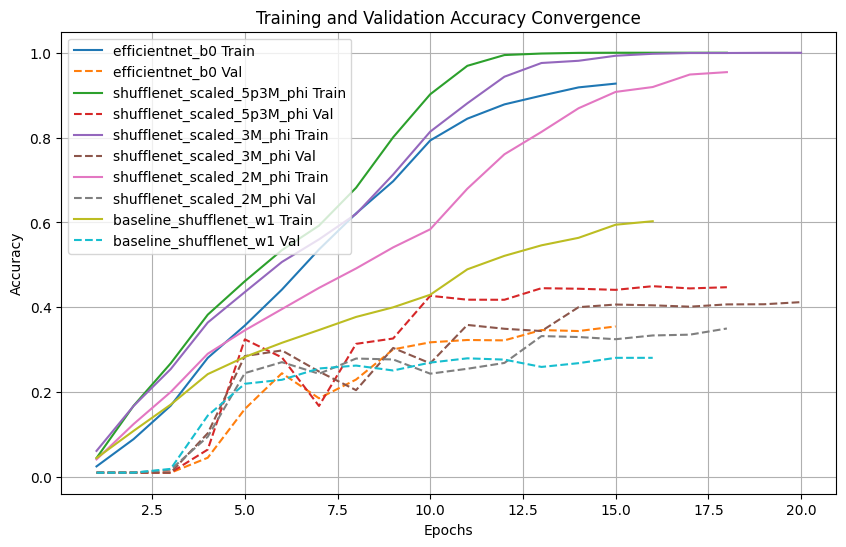

In [ ]:
# training from third model onwards
for name, mdl in models_to_train[::-1][2:]:
    model_res = getattr(mdl, "_meta", {}).get("resolution", BASE_RESOLUTION)
    train_ds = make_dataset(train_paths, train_labels, img_size=model_res, batch_size=BATCH_SIZE, shuffle=True)
    val_ds   = make_dataset(val_paths, val_labels, img_size=model_res, batch_size=BATCH_SIZE, shuffle=False)
    test_ds  = make_dataset(test_paths, test_labels, img_size=model_res, batch_size=BATCH_SIZE, shuffle=False)

    res = train_one_model(name, mdl, train_ds, val_ds, test_ds, epochs=EPOCHS, lr=LR, patience=PATIENCE)
    results.append(res)

# summary
print("\n\n")
for r in results:
    print(f"{r['model_name']}: params={r['params']}, test_acc={r['test_acc']:.4f}, time_s={r['training_time_s']:.1f}")

# plot convergence
plt.figure(figsize=(10, 6))
for r in results:
    history = r["history"]
    epochs_range = range(1, len(history["accuracy"]) + 1)
    plt.plot(epochs_range, history["accuracy"], label=f"{r['model_name']} Train")
    plt.plot(epochs_range, history["val_accuracy"], '--', label=f"{r['model_name']} Val")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Convergence")
plt.legend()
plt.grid(True)
plt.show()

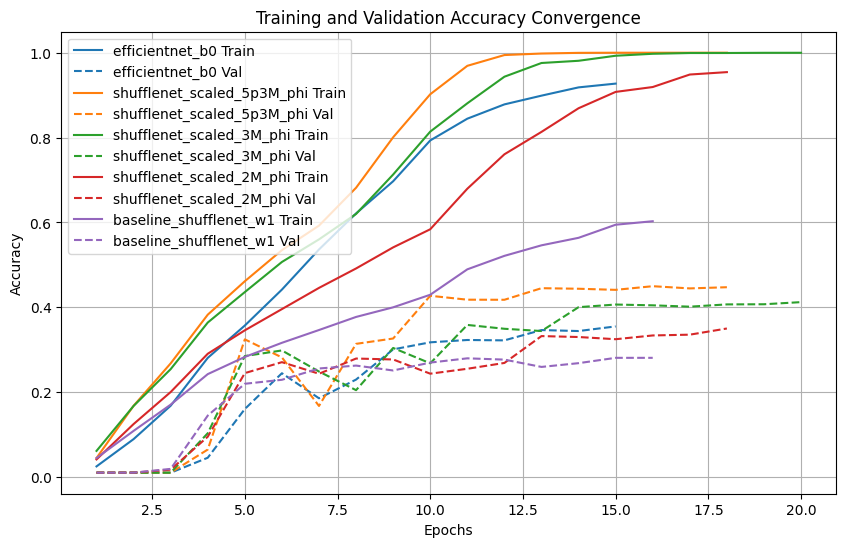

In [ ]:
# generate clearer plot with proper colour pairing
import itertools

plt.figure(figsize=(10, 6))
color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

for r in results:
    c = next(color_cycle)  # one color per model
    history = r["history"]
    epochs_range = range(1, len(history["accuracy"]) + 1)

    plt.plot(epochs_range, history["accuracy"], color=c, label=f"{r['model_name']} Train")
    plt.plot(epochs_range, history["val_accuracy"], '--', color=c, label=f"{r['model_name']} Val")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Convergence")
plt.legend()
plt.grid(True)
plt.show()

### Final Evaluation

Evaluate top-1 and top-5 accuracies on the test dataset

In [ ]:
from pathlib import Path
from tensorflow.keras.metrics import TopKCategoricalAccuracy

model_dir = Path("/content/drive/MyDrive/Task3/tmp")

custom_objs = {
    "ChannelShuffle": ChannelShuffle,
    "ShuffleSplit": ShuffleSplit,
}

for model_path in sorted(model_dir.glob("*_best.keras")):
    print(f"\nEvaluating: {model_path.name}...")

    # load model with custom layers
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objs)

    # extract input resolution from model
    _, h, w, _ = model.input_shape
    model_res = h  # assuming square images

    # build test dataset with the model's input size
    test_ds_eval = make_dataset(test_paths, test_labels, img_size=model_res, batch_size=BATCH_SIZE, shuffle=False)

    # evaluate base metrics
    test_loss, test_acc = model.evaluate(test_ds_eval, verbose=0)
    print(f"Loss: {test_loss:.4f} | Top-1 (eval): {test_acc:.4f}")

    # compute top-1 and top-5 accuracies manually
    top1 = TopKCategoricalAccuracy(k=1)
    top5 = TopKCategoricalAccuracy(k=5)

    for x, y in test_ds_eval:
        preds = model(x, training=False)
        top1.update_state(y, preds)
        top5.update_state(y, preds)

    print(f"Top-1: {top1.result().numpy():.4f} | Top-5: {top5.result().numpy():.4f}")


Evaluating: baseline_shufflenet_w1_best.keras...
Loss: 3.0481 | Top-1 (eval): 0.2840
Top-1: 0.2840 | Top-5: 0.5656

Evaluating: efficientnet_b0_best.keras...
Loss: 3.2456 | Top-1 (eval): 0.3198
Top-1: 0.3198 | Top-5: 0.6075

Evaluating: shufflenet_scaled_2M_phi_best.keras...
Loss: 2.8836 | Top-1 (eval): 0.3262
Top-1: 0.3262 | Top-5: 0.6340

Evaluating: shufflenet_scaled_3M_phi_best.keras...
Loss: 2.5441 | Top-1 (eval): 0.4113
Top-1: 0.4113 | Top-5: 0.7083

Evaluating: shufflenet_scaled_5p3M_phi_best.keras...
Loss: 2.3431 | Top-1 (eval): 0.4601
Top-1: 0.4601 | Top-5: 0.7324


Calculate the number of FLOPS for single inference

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

# flops calculation function
def get_flops(model, batch_size=1):
    concrete_func = tf.function(lambda x: model(x)).get_concrete_function(
        tf.TensorSpec([batch_size] + list(model.input_shape[1:]), tf.float32)
    )
    frozen_func, _ = convert_variables_to_constants_v2_as_graph(concrete_func)

    with tf.Graph().as_default() as g:
        tf.graph_util.import_graph_def(frozen_func.graph.as_graph_def(), name="")
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(g, run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops

# loop through models
for model_path in sorted(model_dir.glob("*_best.keras")):
    print(f"\nModel: {model_path.name}")

    # load model with custom layers
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objs)

    # parameters count
    params = model.count_params()

    # compute FLOPs
    flops = get_flops(model)

    print(f"Parameters: {params:,}")
    print(f"FLOPs per forward pass: {flops:,} ({flops / 1e9:.2f} GFLOPs)")


Model: baseline_shufflenet_w1_best.keras


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Parameters: 452,244
FLOPs per forward pass: 81,909,512 (0.08 GFLOPs)

Model: efficientnet_b0_best.keras
Parameters: 4,177,671
FLOPs per forward pass: 800,740,719 (0.80 GFLOPs)

Model: shufflenet_scaled_2M_phi_best.keras
Parameters: 1,085,828
FLOPs per forward pass: 320,403,288 (0.32 GFLOPs)

Model: shufflenet_scaled_3M_phi_best.keras
Parameters: 2,078,220
FLOPs per forward pass: 837,760,152 (0.84 GFLOPs)

Model: shufflenet_scaled_5p3M_phi_best.keras
Parameters: 4,396,784
FLOPs per forward pass: 2,216,197,472 (2.22 GFLOPs)
